<a href="https://colab.research.google.com/github/yshnxd/solaris/blob/main/Solaris_10_Stable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Libraries

In [ ]:
# Install yfinance if not already installed
!pip install yfinance --upgrade --quiet

# Import core libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

!pip install ta

# Collect Data

In [ ]:
from datetime import datetime, timedelta
import yfinance as yf

end_date = datetime.today()
start_date = end_date - timedelta(days=729)

data = yf.download("AAPL", start=start_date.strftime('%Y-%m-%d'),
                   end=end_date.strftime('%Y-%m-%d'),
                   interval="1h")

print(data.shape)

# Flatten column names if they’re multi-level
data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns]


/tmp/ipython-input-10-2402666189.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start=start_date.strftime('%Y-%m-%d'),
[*********************100%***********************]  1 of 1 completed

(3480, 5)


#eature Creation

Creating Features

In [ ]:
import numpy as np
import pandas as pd

from ta.trend import MACD, ADXIndicator, EMAIndicator, CCIIndicator
from ta.momentum import RSIIndicator, StochRSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, MFIIndicator


def build_features(
    data: pd.DataFrame,
    horizon: int = 1,          # predict t+1 by default
    rsi_window: int = 14,
    bb_window: int = 20,
    ma_windows = (5, 10, 20, 50, 100, 200),
    vol_windows = (10, 20),
) -> pd.DataFrame:
    """
    Expects columns: ['Open','High','Low','Close','Volume'] and a DatetimeIndex (or a 'Date' column).
    Returns a DataFrame with engineered features + future price/dir labels.
    """

    df = data.copy()

    # Ensure datetime index
    if 'Date' in df.columns and not isinstance(df.index, pd.DatetimeIndex):
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)

    # ---------- Basic returns ----------
    df['ret_1'] = df['Close'].pct_change()
    df['log_ret'] = np.log1p(df['ret_1'])

    for w in vol_windows:
        df[f'vol_{w}'] = df['log_ret'].rolling(w).std()

    # ---------- Moving Averages / EMAs ----------
    for w in ma_windows:
        df[f'SMA_{w}'] = df['Close'].rolling(window=w).mean()
        df[f'EMA_{w}'] = df['Close'].ewm(span=w, adjust=False).mean()

    # ---------- RSI ----------
    rsi = RSIIndicator(close=df['Close'], window=rsi_window)
    df[f'RSI_{rsi_window}'] = rsi.rsi()

    # ---------- StochRSI ----------
    stoch = StochRSIIndicator(close=df['Close'], window=rsi_window, smooth1=3, smooth2=3)
    df['StochRSI'] = stoch.stochrsi()
    df['StochRSI_k'] = stoch.stochrsi_k()
    df['StochRSI_d'] = stoch.stochrsi_d()

    # ---------- MACD ----------
    macd = MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
    df['MACD'] = macd.macd()
    df['MACD_signal'] = macd.macd_signal()
    df['MACD_hist'] = macd.macd_diff()

    # ---------- Bollinger Bands ----------
    bb = BollingerBands(close=df['Close'], window=bb_window, window_dev=2)
    df['BB_upper'] = bb.bollinger_hband()
    df['BB_lower'] = bb.bollinger_lband()
    df['BB_bandwidth'] = (df['BB_upper'] - df['BB_lower']) / df['Close']

    # ---------- ATR ----------
    atr = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14)
    df['ATR_14'] = atr.average_true_range()

    # ---------- ADX ----------
    adx = ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=14)
    df['ADX_14'] = adx.adx()
    df['ADX_pos'] = adx.adx_pos()
    df['ADX_neg'] = adx.adx_neg()

    # ---------- CCI ----------
    cci = CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=20)
    df['CCI_20'] = cci.cci()

    # ---------- Volume-based ----------
    df['Vol_Pct_Change'] = df['Volume'].pct_change()
    for w in (10, 20):
        df[f'Vol_MA_{w}'] = df['Volume'].rolling(w).mean()
        df[f'Vol_zscore_{w}'] = (df['Volume'] - df[f'Vol_MA_{w}']) / df['Volume'].rolling(w).std()

    obv = OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume'])
    df['OBV'] = obv.on_balance_volume()

    mfi = MFIIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=14)
    df['MFI_14'] = mfi.money_flow_index()

    # ---------- Price structure ----------
    df['HL_range'] = df['High'] - df['Low']
    df['OC_range'] = df['Close'] - df['Open']

    # ---------- Lags ----------
    for lag in [1, 2, 3, 5, 10]:
        df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
        df[f'ret_lag_{lag}'] = df['ret_1'].shift(lag)

    # ---------- Cyclical time features ----------
    df['dow'] = df.index.dayofweek
    df['month'] = df.index.month
    df['sin_dow'] = np.sin(2 * np.pi * df['dow'] / 7)
    df['cos_dow'] = np.cos(2 * np.pi * df['dow'] / 7)
    df['sin_month'] = np.sin(2 * np.pi * df['month'] / 12)
    df['cos_month'] = np.cos(2 * np.pi * df['month'] / 12)

    # ---------- Targets (for later stages) ----------
    df['future_close'] = df['Close'].shift(-horizon)
    df['future_ret'] = (df['future_close'] - df['Close']) / df['Close']
    df['direction'] = (df['future_close'] > df['Close']).astype(int)

    df = df.dropna().copy()
    return df


Normalization

Scaling

# Preprocessing

Normalize Features

In [ ]:
# --- 1. Normalize Features ---
feature_cols = data.columns.difference(['Close'])  # All except target
target_col = 'Close'
# Fix: Clean inf and NaN before scaling
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

data_scaled = data.copy()
data_scaled[feature_cols] = scaler_features.fit_transform(data_scaled[feature_cols])
data_scaled[target_col] = scaler_target.fit_transform(data_scaled[[target_col]])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# --- SETTINGS ---
time_step = 30


# --- 2. Create Dataset for CNN & LSTM ---
def create_cnn_lstm_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data.iloc[i:(i + time_step)].values)
        y.append(data.iloc[i + time_step][target_col])
    return np.array(X), np.array(y)

X_seq, y_seq = create_cnn_lstm_dataset(data_scaled, time_step)

# --- 3. Create Dataset for XGBoost (Tabular, No 3D) ---
def create_xgb_dataset(data, time_step):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data.iloc[i:(i + time_step)].values.flatten())  # Flatten time steps
        y.append(data.iloc[i + time_step][target_col])
    return np.array(X), np.array(y)

X_xgb, y_xgb = create_xgb_dataset(data_scaled, time_step)

# --- 4. Train/Test Split ---
split_index = int(len(X_seq) * 0.8)

# CNN-LSTM Inputs
X_seq_train, X_seq_test = X_seq[:split_index], X_seq[split_index:]
y_seq_train, y_seq_test = y_seq[:split_index], y_seq[split_index:]

# XGBoost Inputs
X_xgb_train, X_xgb_test = X_xgb[:split_index], X_xgb[split_index:]
y_xgb_train, y_xgb_test = y_xgb[:split_index], y_xgb[split_index:]

# --- 5. Create Direction Labels (Up = 1, Down = 0) ---
def create_direction_labels(y_true):
    return np.where(np.diff(y_true, prepend=y_true[0]) > 0, 1, 0)

y_seq_direction_train = create_direction_labels(y_seq_train)
y_seq_direction_test = create_direction_labels(y_seq_test)

y_xgb_direction_train = create_direction_labels(y_xgb_train)
y_xgb_direction_test = create_direction_labels(y_xgb_test)


# Build the Model

CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # Regression output
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mae')
    return model


LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Regression output
    model.compile(optimizer='adam', loss='mae')
    return model


XGBOOST

In [ ]:
from xgboost import XGBRegressor

def build_xgb_model():
    return XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        objective='reg:squarederror'
    )


# Train the model

CNN

In [ ]:
cnn_model = build_cnn_model(input_shape=X_seq_train.shape[1:])

cnn_model.compile(optimizer='adam', loss='mse')
cnn_history = cnn_model.fit(
    X_seq_train, y_seq_train,
    validation_data=(X_seq_test, y_seq_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0686 - val_loss: 0.0051
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0061 - val_loss: 0.0033
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0056 - val_loss: 0.0026
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0051 - val_loss: 0.0026
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0051 - val_loss: 0.0037
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0042 - val_loss: 0.0026
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 9/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 10/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0037 - val_loss: 0.0019
Epoch 11/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035 - val_loss: 0.0015
Epoch 12/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0033 - val_

LSTM

In [ ]:
lstm_model = build_lstm_model(input_shape=X_seq_train.shape[1:])

lstm_model.compile(optimizer='adam', loss='mse')
lstm_history = lstm_model.fit(
    X_seq_train, y_seq_train,
    validation_data=(X_seq_test, y_seq_test),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0596 - val_loss: 0.0027
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0037 - val_loss: 0.0016
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 9/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 10/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 11/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 12/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0011 - val_l

XGBOOST

In [ ]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_reg.fit(
    X_xgb_train, y_xgb_train.ravel(),
    eval_set=[(X_xgb_test, y_xgb_test.ravel())],
    verbose=10
)


[0]	validation_0-rmse:0.11242
[10]	validation_0-rmse:0.04778
[20]	validation_0-rmse:0.03554
[30]	validation_0-rmse:0.03507
[40]	validation_0-rmse:0.03433
[50]	validation_0-rmse:0.03406
[60]	validation_0-rmse:0.03393
[70]	validation_0-rmse:0.03400
[80]	validation_0-rmse:0.03407
[90]	validation_0-rmse:0.03405
[99]	validation_0-rmse:0.03400


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

Plot

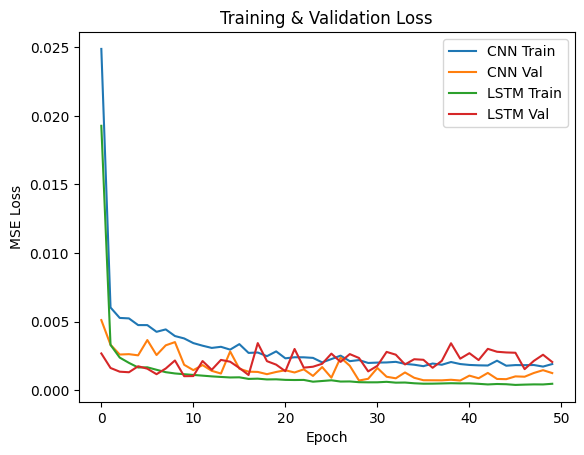

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cnn_history.history['loss'], label='CNN Train')
plt.plot(cnn_history.history['val_loss'], label='CNN Val')
plt.plot(lstm_history.history['loss'], label='LSTM Train')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


# META LEARNER

get model predictions

In [ ]:
# Predict next price using trained models
cnn_preds = cnn_model.predict(X_seq_test)
lstm_preds = lstm_model.predict(X_seq_test)
xgb_preds = xgb_reg.predict(X_xgb_test)

# Ensure 2D shape
cnn_preds = cnn_preds.reshape(-1, 1)
lstm_preds = lstm_preds.reshape(-1, 1)
xgb_preds = xgb_preds.reshape(-1, 1)
y_actual = y_seq_test.flatten()

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Create Meta-Features

In [ ]:
import numpy as np

def generate_direction_labels(prices: np.ndarray, threshold=0.001):
    """
    Generate binary direction labels:
    - 1 if price increased above threshold
    - 0 if dropped or stayed nearly the same
    """
    deltas = np.diff(prices)
    labels = np.where(deltas > threshold, 1, 0)
    return labels


In [ ]:
# Prepend current_prices[0] to make the diff align
true_price_series = np.concatenate([[current_prices[0]], actual_prices])
y_meta = generate_direction_labels(true_price_series, threshold=0.001)


In [ ]:
# current_prices: predicted from your test input windows
# actual_prices: real prices to compare

# Model predictions (already loaded)
cnn_preds = cnn_model.predict(X_seq_test).flatten()
lstm_preds = lstm_model.predict(X_seq_test).flatten()
xgb_preds = xgb_reg.predict(X_xgb_test).flatten()

# Ensure all preds and current_prices are the same shape
current_prices = X_seq_test[:, -1, 0][-len(cnn_preds):]
actual_prices = y_seq_test[-len(cnn_preds):]  # safe align

# Feature Engineering: DELTAS
cnn_deltas = cnn_preds - current_prices
lstm_deltas = lstm_preds - current_prices
xgb_deltas = xgb_preds - current_prices

X_meta = np.stack([cnn_deltas, lstm_deltas, xgb_deltas], axis=1)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Stack Predictions for Meta-Classifier

In [ ]:
# Prepend current_prices[0] to make the diff align
true_price_series = np.concatenate([[current_prices[0]], actual_prices])
y_meta = generate_direction_labels(true_price_series, threshold=0.001)


In [ ]:
from collections import Counter
print(Counter(y_meta))  # See if it's balanced or not


Counter({np.int64(0): 361, np.int64(1): 325})


Train Meta-Classifier (Logistic Regression or XGBoost)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ Meta-Learner Accuracy: 0.47101449275362317
✅ F1 Score: 0.43410852713178294
✅ Precision: 0.49122807017543857
✅ Recall: 0.3888888888888889
              precision    recall  f1-score   support

           0       0.46      0.56      0.50        66
           1       0.49      0.39      0.43        72

    accuracy                           0.47       138
   macro avg       0.47      0.47      0.47       138
weighted avg       0.47      0.47      0.47       138

Feature ranking:
1. Feature 4: 0.2113
2. Feature 1: 0.2046
3. Feature 0: 0.1974
4. Feature 3: 0.1954
5. Feature 2: 0.1913


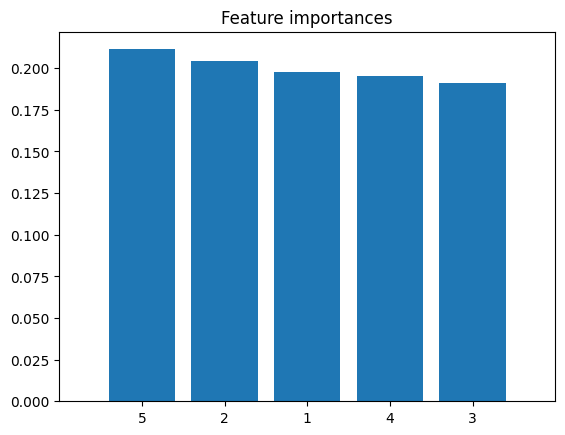

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# === Step 1: Get predictions from trained models ===
cnn_preds = cnn_model.predict(X_seq_test).flatten()
lstm_preds = lstm_model.predict(X_seq_test).flatten()
xgb_preds = xgb_reg.predict(X_xgb_test).flatten()

# === Step 2: Align current & future prices ===
current_prices = X_seq_test[:, -1, 0][-len(cnn_preds):]   # Last price of each input window
actual_prices = y_seq_test[-len(cnn_preds):]              # True future price (next time step)

# === Step 3: Create DELTA features ===
cnn_deltas = cnn_preds - current_prices
lstm_deltas = lstm_preds - current_prices
xgb_deltas = xgb_preds - current_prices

# === Step 4: Stack deltas into meta-feature input ===
X_meta = np.stack([cnn_deltas, lstm_deltas, xgb_deltas], axis=1)

# Additional features: mean and std of deltas
mean_deltas = np.mean(X_meta, axis=1)
std_deltas = np.std(X_meta, axis=1)
X_meta = np.column_stack((X_meta, mean_deltas, std_deltas))

# === Step 5: Generate labels (1 if price up, 0 if flat/down) ===
def generate_direction_labels(prices: np.ndarray, threshold=0.001):
    deltas = np.diff(prices)
    return np.where(deltas > threshold, 1, 0)

# Reconstruct full price series to compute change
true_price_series = np.concatenate([[current_prices[0]], actual_prices])
y_meta = generate_direction_labels(true_price_series, threshold=0.001)

# === Step 6: Train Meta-Learner ===
X_train_meta, X_val_meta, y_train_meta, y_val_meta = train_test_split(
    X_meta, y_meta, test_size=0.2, random_state=42
)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', None]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_meta, y_train_meta)

# Best model from grid search
meta_model = grid_search.best_estimator_

# === Step 7: Predict and Evaluate ===
meta_preds = meta_model.predict(X_val_meta)
acc = accuracy_score(y_val_meta, meta_preds)
f1 = f1_score(y_val_meta, meta_preds)
precision = precision_score(y_val_meta, meta_preds)
recall = recall_score(y_val_meta, meta_preds)

print("✅ Meta-Learner Accuracy:", acc)
print("✅ F1 Score:", f1)
print("✅ Precision:", precision)
print("✅ Recall:", recall)
print(classification_report(y_val_meta, meta_preds))

# === Step 8: Feature Importance Visualization ===
importances = meta_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_meta.shape[1]):
    print(f"{f + 1}. Feature {indices[f]}: {importances[indices[f]]:.4f}")

# Plot the feature importances of the meta-learner
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_meta.shape[1]), importances[indices], align="center")
plt.xticks(range(X_meta.shape[1]), indices + 1)
plt.xlim([-1, X_meta.shape[1]])
plt.show()


# Evaluation

Confusion Matrix

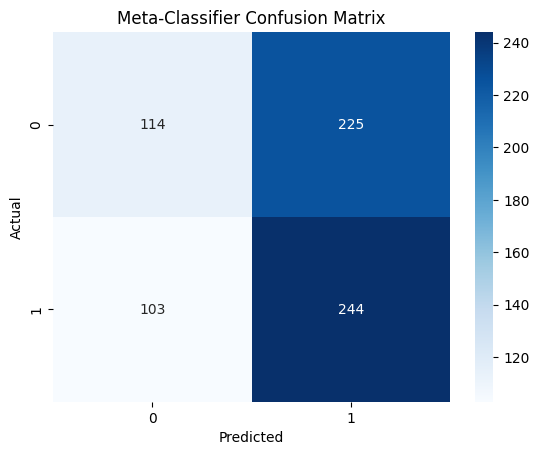

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(meta_labels, meta_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Meta-Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


ROC_AUC CURVE

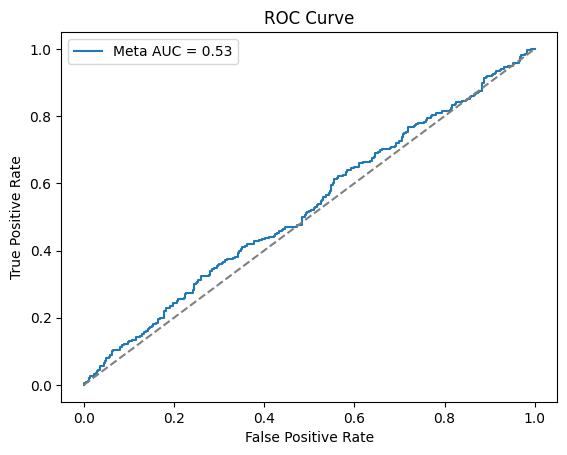

In [ ]:
from sklearn.metrics import roc_curve, auc

meta_probs = meta_clf.predict_proba(meta_features)[:, 1]
fpr, tpr, _ = roc_curve(meta_labels, meta_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"Meta AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# save

In [ ]:
import joblib

# Save models
joblib.dump(meta_clf, "meta_classifier.pkl")
joblib.dump(xgb_reg, "xgboost_reg.pkl")
cnn_model.save("cnn_model.h5")
lstm_model.save("lstm_model.h5")


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Calculate MSE for each model
cnn_mse = mean_squared_error(y_seq_test, cnn_preds)
lstm_mse = mean_squared_error(y_seq_test, lstm_preds)
xgb_mse = mean_squared_error(y_xgb_test, xgb_preds)

# Calculate RMSE by taking the square root of MSE
cnn_rmse = np.sqrt(cnn_mse)
lstm_rmse = np.sqrt(lstm_mse)
xgb_rmse = np.sqrt(xgb_mse)

# Calculate R2 score for each model
cnn_r2 = r2_score(y_seq_test, cnn_preds)
lstm_r2 = r2_score(y_seq_test, lstm_preds)
xgb_r2 = r2_score(y_xgb_test, xgb_preds)

# Print the results
print("CNN RMSE:", cnn_rmse)
print("CNN R2:", cnn_r2)
print("LSTM RMSE:", lstm_rmse)
print("LSTM R2:", lstm_r2)
print("XGB RMSE:", xgb_rmse)
print("XGB R2:", xgb_r2)

CNN RMSE: 0.03538352229727685
CNN R2: 0.9045804153512125
LSTM RMSE: 0.04537000263272948
LSTM R2: 0.8431180407396673
XGB RMSE: 0.034000382648505495
XGB R2: 0.9118945030746076
